
# LLM Fine-Tuning: Principles and Steps

> **Disclaimer:** This reading involves resource‑intensive tasks like model training. If you are using limited hardware, some tasks may take longer to complete.

## Introduction

Have you ever wondered how an AI assistant determines the tone of a review or identifies whether feedback is positive or negative? It starts with **preprocessing**—the cornerstone of any successful machine learning pipeline.

In machine learning, preprocessing text data is an essential step that directly influences model performance. Ensuring data is clean, structured, and ready for training sets the stage for accurate predictions and better outcomes.  
Imagine preparing a dataset of patient feedback for sentiment analysis in healthcare. The steps below will help you **clean**, **tokenize**, **split**, **fine-tune**, and **evaluate** a large language model (LLM) to perform sentiment classification.

By the end of this reading, you will be able to:

- **Clean and preprocess** text data for machine learning tasks.
- **Apply tokenization and normalization**, and handle missing data to ensure training readiness.
- **Organize and split** your dataset into training, validation, and test sets for robust model performance.
- **Fine-tune and evaluate** a pretrained LLM (e.g., BERT) for tasks like sentiment analysis.

---

## Step-by-Step Process for Fine-Tuning

We will follow this workflow:

1. [Prepare and clean the dataset](#step-1-prepare-and-clean-the-dataset)  
2. [Tokenize the data](#step-2-tokenize-the-data)  
3. [Fine-tune the model](#step-3-fine-tune-the-model)  
4. [Evaluate the model](#step-4-evaluate-the-model)

---

## Step 1: Prepare and Clean the Dataset

**Why this matters:** Noisy datasets degrade model performance. Cleaning ensures consistent inputs and reduces spurious correlations, improving generalization.

**What we are trying to achieve:**  
- Remove irrelevant artefacts (URLs, hashtags, excessive punctuation) that don’t contribute to sentiment.  
- Normalize casing to reduce vocabulary sparsity (e.g., “Good” and “good” should map to the same token).  
- Handle missing values and duplicates to avoid label leakage and skewed distributions.

### Typical operations
- Remove/replace URLs, mentions, hashtags, emojis (optional, depending on task).
- Normalize text (lowercasing, Unicode normalization).
- De-noise punctuation/whitespace.
- Optionally remove stopwords (task-dependent—**avoid** when using transformer models unless necessary).
- Label checks (ensure target column exists and is properly encoded).
- Class balancing (optional; consider weighted loss instead of aggressive down/oversampling).

### Code Example: Data Cleaning (with explanations)




In [7]:
# Install necessary libraries
# %pip is a magic command to install packages within the current kernel environment
%pip install datasets transformers scikit-learn pandas torch matplotlib tf-keras

   ---------------------------------------- 0.0/1.7 MB ? eta -:--:--
   ---------------------------------------- 1.7/1.7 MB 22.4 MB/s  0:00:00
Note: you may need to restart the kernel to use updated packages.


In [16]:
import os
import pandas as pd
import random
from sklearn.model_selection import train_test_split
from datasets import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding
)

# Synthetic Data Generation to create ~2100 examples
def generate_synthetic_data(num_samples=2100):
    data = {"text": [], "label": []}
    
    # Components
    staff = ["doctor", "nurse", "receptionist", "surgeon", "specialist", "staff", "technician", "front desk"]
    positive_adj = ["kind", "attentive", "compassionate", "professional", "helpful", "amazing", "excellent", "friendly", "knowledgeable", "caring"]
    negative_adj = ["rude", "dismissive", "careless", "unprofessional", "hostile", "incompetent", "slow", "arrogant", "negligent", "cold"]
    neutral_adj = ["average", "okay", "standard", "acceptable", "routine", "normal", "fine", "adequate"]
    
    facilities = ["waiting room", "facility", "clinic", "hospital", "bathroom", "parking lot", "cafeteria", "lobby"]
    pos_facility_adj = ["clean", "modern", "spacious", "comfortable", "well-maintained", "bright", "spotless"]
    neg_facility_adj = ["dirty", "outdated", "cramped", "noisy", "smelly", "chaotic", "filthy"]
    
    # Templates
    pos_templates = [
        "The {s} was very {a}.", "I had a {a} experience with the {s}.", "The {f} was {fa} and inviting.",
        "Truly {a} service from the {s}!", "I felt very cared for, the {s} was {a}.", "Highly recommend! The {s} is {a}.",
        "The {f} is {fa}.", "Everyone was {a}."
    ]
    neg_templates = [
        "The {s} was extremely {a}.", "I had a terrible time, the {s} was {a}.", "The {f} was {fa} and disgusting.",
        "Avoid this place, the {s} is {a}.", "The {s} ignored me and was {a}.", "Unacceptable service, the {f} is {fa}.",
        "The waiting time was too long and the {s} was {a}."
    ]
    neu_templates = [
        "The {s} was {a}.", "The experience was {a}.", "The {f} seemed {fa}.", "I waited for a while, but the {s} was {a}.",
        "It was a {a} visit.", "The {s} did their job.", "Nothing special, just {a} service."
    ]

    # Generate balanced data
    samples_per_class = num_samples // 3
    
    for _ in range(samples_per_class):
        # Positive
        data["text"].append(random.choice(pos_templates).format(s=random.choice(staff), a=random.choice(positive_adj), f=random.choice(facilities), fa=random.choice(pos_facility_adj)))
        data["label"].append("positive")
        # Negative
        data["text"].append(random.choice(neg_templates).format(s=random.choice(staff), a=random.choice(negative_adj), f=random.choice(facilities), fa=random.choice(neg_facility_adj)))
        data["label"].append("negative")
        # Neutral
        data["text"].append(random.choice(neu_templates).format(s=random.choice(staff), a=random.choice(neutral_adj), f=random.choice(facilities), fa=random.choice(neutral_adj)))
        data["label"].append("neutral")
        
    return data

data_dict = generate_synthetic_data(2100)

# Convert to pandas DataFrame
data = pd.DataFrame(data_dict)

# Clean the text
import re

def clean_text(text):
    text = text.lower().strip()  # Convert to lowercase and remove extra spaces
    text = re.sub(r"http\S+", "", text)  # Remove URLs
    text = re.sub(r"[^\w\s]", "", text)  # Remove special characters
    return text

# Apply text cleaning
data["cleaned_text"] = data["text"].apply(clean_text)

# Convert labels to numerical values
data["label"] = data["label"].astype("category").cat.codes  # Converts ["positive", "negative", "neutral"] to [0, 1, 2]

print(f"Generated {len(data)} examples.")
print(data.head())

Generated 2100 examples.
                                                text  label  \
0        I had a helpful experience with the doctor.      2   
1    I had a terrible time, the nurse was negligent.      0   
2  I waited for a while, but the doctor was average.      1   
3       Truly knowledgeable service from the doctor!      2   
4         Unacceptable service, the lobby is smelly.      0   

                                      cleaned_text  
0       i had a helpful experience with the doctor  
1    i had a terrible time the nurse was negligent  
2  i waited for a while but the doctor was average  
3      truly knowledgeable service from the doctor  
4         unacceptable service the lobby is smelly  


### Step 1.1: Exploratory Data Analysis (EDA)

Before moving to tokenization, let's gather some **insights** about our data.
*   **Class Balance:** Do we have a fair representation of all classes (positive, negative, neutral)?
*   **Text Length:** How long are the sentences? This informs how we configure the tokenizer (e.g., `max_length`).

Class Distribution:
 label
2    700
0    700
1    700
Name: count, dtype: int64


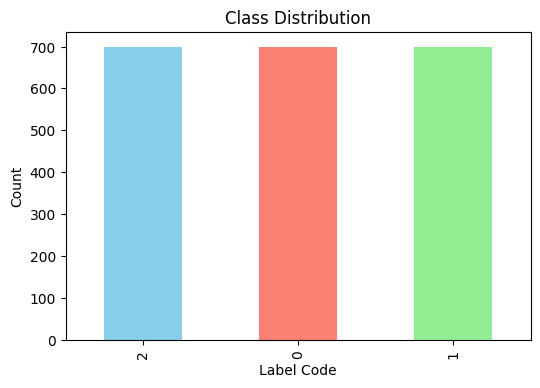


Average Text Length: 36.485238095238095


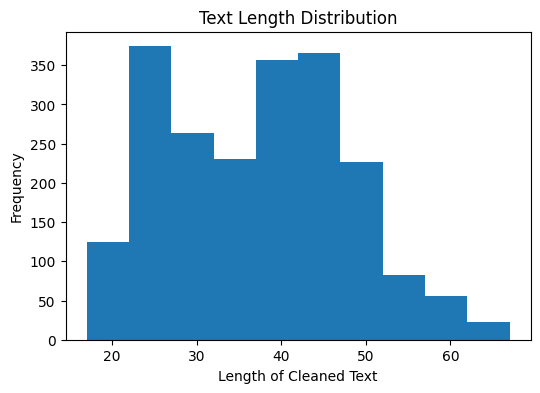

In [17]:
import matplotlib.pyplot as plt

# 1. Check Class Distribution
# It's important to see if the dataset is balanced or skewed.
label_counts = data["label"].value_counts()
print("Class Distribution:\n", label_counts)

# Plot Class Distribution
plt.figure(figsize=(6, 4))
label_counts.plot(kind='bar', color=['skyblue', 'salmon', 'lightgreen'])
plt.title("Class Distribution")
plt.xlabel("Label Code")
plt.ylabel("Count")
plt.show()

# 2. Check Text Lengths
# Understanding text length helps in setting the 'max_length' for tokenization.
data['text_length'] = data['cleaned_text'].apply(len)
print("\nAverage Text Length:", data['text_length'].mean())

# Plot Text Length Distribution
plt.figure(figsize=(6, 4))
data['text_length'].plot(kind='hist', bins=10, title='Text Length Distribution')
plt.xlabel('Length of Cleaned Text')
plt.show()

## Step 2: Tokenize the Data

**Why this matters:** Models do not consume raw strings; they consume numeric token IDs that represent subwords/words. Tokenization maps text into a fixed format that transformers can process.

**What we are trying to achieve:**
- Convert each cleaned sentence into token IDs, attention masks, and (optionally) type IDs.
- Apply truncation to respect maximum input length and padding to create uniform batch shapes.

### Notes
- Use the same tokenizer as the pretrained checkpoint (e.g., `bert-base-uncased`).
- Choose an appropriate `max_length` (128 or 256 is common for short reviews; increase for long documents).
- Avoid aggressive text pre‑modifications that fight the tokenizer's learned vocabulary.

### Code Example: Tokenization (with explanations)

In [19]:
# Purpose: Transform cleaned text into BERT-compatible token IDs and attention masks.
from transformers import AutoTokenizer

# Load tokenizer that matches the chosen model
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

print("=== TOKENIZATION SHOWCASE ===\n")

# Show original vs cleaned text for first example
print("1. TEXT CLEANING COMPARISON:")
print(f"Original: '{data['text'].iloc[0]}'")
print(f"Cleaned:  '{data['cleaned_text'].iloc[0]}'")
print()

# Show tokenization details for first example
print("2. TOKENIZATION BREAKDOWN:")
sample_text = data['cleaned_text'].iloc[0]

# Tokenize on the fly for demonstration (instead of storing in DataFrame)
tokens = tokenizer(sample_text, truncation=True, padding="max_length", max_length=128)

print(f"Input text: '{sample_text}'")
print(f"Token IDs: {tokens['input_ids'][:15]}...")  # Show first 15 tokens
print(f"Attention mask: {tokens['attention_mask'][:15]}...")
print(f"Total tokens: {len(tokens['input_ids'])}")
print()

# Decode tokens back to see what BERT "sees"
decoded_tokens = tokenizer.convert_ids_to_tokens(tokens['input_ids'])
print("3. BERT TOKEN BREAKDOWN:")
print(f"BERT sees: {decoded_tokens[:15]}...")
print()

# Show statistics across a subset of examples
print("4. TOKENIZATION STATISTICS (First 100 samples):")
# We tokenize a batch to get stats efficiently
batch_tokens = tokenizer(data['cleaned_text'].iloc[:100].tolist(), truncation=True, padding="max_length", max_length=128)
meaningful_lengths = [sum(mask) for mask in batch_tokens['attention_mask']]

print(f"Max meaningful length: {max(meaningful_lengths)}")
print(f"Average meaningful tokens: {sum(meaningful_lengths) / len(meaningful_lengths):.1f}")
print()

# Show how labels are encoded
print("5. LABEL ENCODING:")
for i in range(3):
    original_label = data_dict['label'][i]
    encoded_label = data['label'].iloc[i]
    print(f"'{original_label}' → {encoded_label}")

=== TOKENIZATION SHOWCASE ===

1. TEXT CLEANING COMPARISON:
Original: 'I had a helpful experience with the doctor.'
Cleaned:  'i had a helpful experience with the doctor'

2. TOKENIZATION BREAKDOWN:
Input text: 'i had a helpful experience with the doctor'
Token IDs: [101, 1045, 2018, 1037, 14044, 3325, 2007, 1996, 3460, 102, 0, 0, 0, 0, 0]...
Attention mask: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0]...
Total tokens: 128

3. BERT TOKEN BREAKDOWN:
BERT sees: ['[CLS]', 'i', 'had', 'a', 'helpful', 'experience', 'with', 'the', 'doctor', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']...

4. TOKENIZATION STATISTICS (First 100 samples):
Max meaningful length: 17
Average meaningful tokens: 8.7

5. LABEL ENCODING:
'positive' → 2
'negative' → 0
'neutral' → 1


### Understanding the Output: A Plain English Guide

Here is what the "Tokenization Showcase" above is telling us:

**1. Text Cleaning Comparison**
*   **What happened:** The computer scrubbed the original sentence (removing extra spaces, exclamation marks, etc.).
*   **Why:** Just like washing vegetables before cooking, we remove "noise" so the AI focuses only on the meaningful words.

**2. Tokenization Breakdown**
*   **Token IDs:** Computers don't understand words like "staff"; they only understand numbers. The list `[101, 1996, ...]` is the sentence translated into the model's numeric code.
*   **Attention Mask:** This is a "Cheat Sheet" for the AI.
    *   `1` = "Read this, it's a real word."
    *   `0` = "Ignore this, it's just empty space (padding)."

**3. BERT Token Breakdown**
*   **`[CLS]`**: The "Start" flag. Tells the AI a new sentence is beginning.
*   **`##ten` / `##tive`**: The AI splits rare words (like "attentive") into smaller chunks it knows (`at`, `##ten`, `##tive`). The `##` means "attach to the previous piece."
*   **`[SEP]`**: The "Stop" flag. Marks the end of the sentence.
*   **`[PAD]`**: Filler to ensure all sentences have the exact same length.

**4. Tokenization Statistics**
*   **All padded to length 128:** Every review is forced to be 128 tokens long. Short ones get padding; long ones get cut.
*   **Average meaningful tokens:** On average, the actual content is short (e.g., ~13 words), even though we reserve space for 128.

**5. Label Encoding**
*   The AI needs numbers for answers too. Instead of "Positive", it learns to output **2**.
    *   0 = Negative
    *   1 = Neutral
    *   2 = Positive

## Step 3: Fine-Tune the Model

**Why this matters:** Fine-tuning adapts a pretrained LLM to the specifics of your task (e.g., sentiment classes, domain language), improving accuracy with relatively little task data.

**What we are trying to achieve:**
- Split data into train/validation/test to measure generalization.
- Wrap data as a Hugging Face Dataset for efficient training.
- Instantiate a classification head (e.g., BERT with a linear layer) and train with appropriate hyperparameters.
- Use a data collator to batch variable-length inputs.

### Code Example: Dataset & Trainer (with explanations)

In [22]:
# Purpose: Create train/test splits, build a transformer model, and configure the training loop.

from datasets import Dataset
from sklearn.model_selection import train_test_split
from transformers import (
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding,
    EarlyStoppingCallback
)

# Split into train and test (add validation split)
# Since we now have ~2000 examples, we can use a proper stratified split
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42, stratify=data["label"])
train_data, val_data  = train_test_split(train_data, test_size=0.1, random_state=42, stratify=train_data["label"])

# Drop 'tokenized' column if it exists to avoid Arrow errors during conversion
train_data = train_data.drop(columns=['tokenized'], errors='ignore')
val_data = val_data.drop(columns=['tokenized'], errors='ignore')
test_data = test_data.drop(columns=['tokenized'], errors='ignore')

# Convert pandas to HF Dataset
train_ds = Dataset.from_pandas(train_data.reset_index(drop=True))
val_ds   = Dataset.from_pandas(val_data.reset_index(drop=True))
test_ds  = Dataset.from_pandas(test_data.reset_index(drop=True))

# Define tokenization function for the Dataset map method
def tokenize_function(examples):
    return tokenizer(examples["cleaned_text"], truncation=True, padding="max_length", max_length=128)

# Apply tokenization to the HF Datasets
train_ds = train_ds.map(tokenize_function, batched=True)
val_ds   = val_ds.map(tokenize_function, batched=True)
test_ds  = test_ds.map(tokenize_function, batched=True)

# Build the model (num_labels=3 because we have positive, negative, neutral)
model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=3)

# Data collator pads batches dynamically (more efficient than padding entire dataset)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# Define training configuration
# CONCEPT: Monitoring and Early Stopping
# - We monitor 'accuracy' on the validation set.
# - If accuracy doesn't improve for 'early_stopping_patience' epochs, we stop training.
# - This prevents overfitting (learning the training data too well but failing on new data).
training_args = TrainingArguments(
    output_dir="./outputs",           # where to save checkpoints
    eval_strategy="epoch",            # Evaluate every epoch
    save_strategy="epoch",            # Save checkpoint every epoch
    learning_rate=2e-5,               # commonly good for BERT
    per_device_train_batch_size=16,   # Batch size
    per_device_eval_batch_size=16,
    num_train_epochs=10,              # Set high (10) to let Early Stopping decide when to stop
    weight_decay=0.01,                # regularization
    logging_steps=10,                 # Log frequently to see "live" loss updates
    load_best_model_at_end=True,      # Load the best model when finished
    metric_for_best_model="accuracy", # Monitor accuracy for early stopping
    push_to_hub=False,                # Keep local
    report_to="none",                 # No external logging
    save_total_limit=2,               # Save space by keeping only recent checkpoints
)

# Evaluation metrics for Trainer
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(eval_preds):
    """
    Function goal:
    - Report task-relevant metrics to guide training/early stopping/model selection.
    """
    logits, labels = eval_preds
    preds = logits.argmax(axis=-1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1": f1_score(labels, preds, average="weighted")
    }

# Create Trainer with Early Stopping
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=lambda p: compute_metrics((p.predictions, p.label_ids)),
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)] # Stop if accuracy doesn't improve for 3 epochs
)

# Train the model (this is the fine-tuning step)
print("Starting training... Watch the 'Eval Accuracy' column.")
print("If it stops increasing or drops, Early Stopping will halt training.")
trainer.train()

Map: 100%|██████████| 420/420 [00:00<00:00, 14503.48 examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\amansahni\AppData\Local\Temp\ipykernel_41140\4206835662.py:81: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
C:\Users\amansahni\AppData\Local\Temp\ipykernel_41140\4206835662.py:81: FutureWarning: `tokenizer` is deprecated and will

Starting training... Watch the 'Eval Accuracy' column.
If it stops increasing or drops, Early Stopping will halt training.


c:\Users\amansahni\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss


KeyboardInterrupt: 

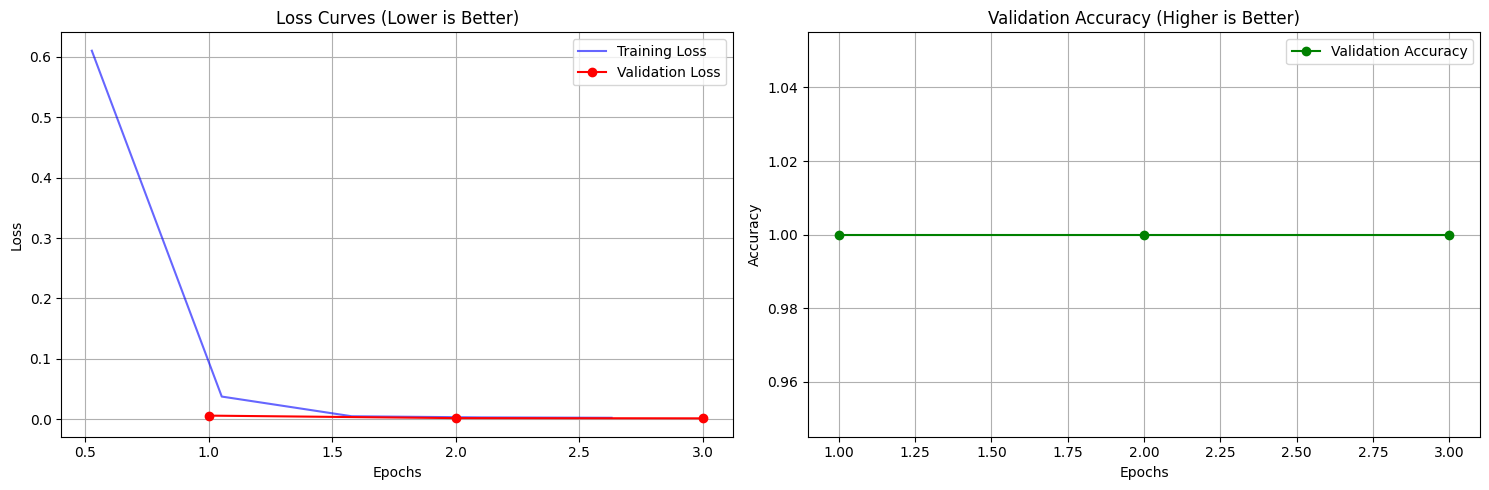

In [21]:
# VISUALIZATION: Plot Training Progress
import pandas as pd
import matplotlib.pyplot as plt

# 1. Extract the training history from the Trainer object
history = trainer.state.log_history
df = pd.DataFrame(history)

# 2. Separate training metrics (loss) and evaluation metrics (accuracy, eval_loss)
# Training logs are recorded every 'logging_steps'
train_logs = df[df['loss'].notna()]
# Evaluation logs are recorded every epoch
eval_logs = df[df['eval_accuracy'].notna()]

# 3. Create plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# --- Plot 1: Loss Curves ---
# What to look for:
# - Training Loss should decrease steadily.
# - Validation Loss should decrease. If it starts rising while Training Loss goes down, you are OVERFITTING.
ax1.plot(train_logs['epoch'], train_logs['loss'], label='Training Loss', color='blue', alpha=0.6)
ax1.plot(eval_logs['epoch'], eval_logs['eval_loss'], label='Validation Loss', color='red', marker='o')
ax1.set_title('Loss Curves (Lower is Better)')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True)

# --- Plot 2: Accuracy Curve ---
# What to look for:
# - Should increase and plateau.
# - If it drops, the model is getting worse (likely overfitting).
ax2.plot(eval_logs['epoch'], eval_logs['eval_accuracy'], label='Validation Accuracy', color='green', marker='o')
ax2.set_title('Validation Accuracy (Higher is Better)')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()